# Political NetworkX Diagram based on Twitter Relationships

Below code will load data from pickle file, apply transformation to fit it according to the needs of the diagramm and eventually load the diagram.
It will allow some insight in political network and interaction between the various parties.

In [1]:
%matplotlib inline
import pickle
import networkx as nx
import matplotlib.pyplot as plt
import pandas.io.sql as sqlio
import pandas as pd
import psycopg2


**Data Load**
Below function load data from DB or from pickle file.

In [2]:

#define DB functions
def select_from_db(sql):
    '''
    Sends an SQL Statement to DB
    :param sql: SQL Statement that will be executed by the DB
    :return: Dataframe with Query Result
    '''
    connection = db_connect()
    df = sqlio.read_sql_query(sql, connection)  # stagin table
    db_close(connection)
    return df


def db_connect():
    '''
    Establishes connection to SQL database
    :return: psycopg2 connection
    '''
    try:
        connection = psycopg2.connect(user=API_Keys.db_users,
                                      password=API_Keys.db_password,
                                      host=API_Keys.db_host,
                                      port=API_Keys.db_port,
                                      database=API_Keys.db_name)

        cursor = connection.cursor()
        cursor.execute("SELECT version();")
    except (Exception, psycopg2.Error) as error:
        print("Error while connecting to PostgreSQL", str(error))
    return connection


def db_close(connection):
    '''
    :param: psycopg2 connection name 
    Closes existing db connection. If no connection is openfunction will end
    '''
    try:
        # closing database connection.
        if (connection):
            cursor.close()
            connection.close()
            print("PostgreSQL connection is closed")
    except:
        pass




**Transform Data to required format and plot diagram**
Using the previously created DB function data is load from DB or from pickle file.
Afterwards nodes and edges for NetworkX are prepared and eventually drawn.

In [5]:

def plot_friend_rel_edges(faction, get_data_from_DB = False, export = False):
    """
    Using the previously created DB function data is load from DB or from pickle file.
    Afterwards nodes and edges for NetworkX are prepared and eventually drawn.
    :param possible factions: 'Union MDBs', 'SPD MDBs', 'AfD', 'Linke MdBs', 'Grüne MDBs', 'FDP MDBs'
    :param get_data_from_DB: True = get data from DB, False = get data from pickle file
    :param if True: saves image as png, if False: displays plot image
    :return: none
    """
    G = nx.Graph()
    twitter_pickle_file = "core_friend_plot.pkl"
    if get_data_from_DB == True:
        #Select defined users from DB and pickle result
        sql = "with all_user_ids as (select user_id from n_cores where screen_name not in ('mlpdde','Die_Gruenen','dieLinke','ZDF','CDU','handelsblatt','NZZ','sebastiankurz','BILD','AfD','welt','titanic','zeitonline','derspiegel','DIEZEIT','tagesschau','SZ','heuteshow','faznet','tazgezwitscher','focusonline','netzpolitik','saschalobo','officiallyjoko','rezomusik','dunjahayali','janboehm')), users1 as (select f.user_id, follows_ids, admin_comment, u.name from n_friends f, n_cores c, n_users u where c.user_id = f.user_id and f.user_id = u.id and f.user_id in (select user_id from all_user_ids)), users2 as (select f.user_id, follows_ids, admin_comment from n_friends f, n_cores c where c.user_id = f.user_id and f.user_id in (select user_id from all_user_ids)) select distinct users1.user_id as core_id, users2.user_id as friend_id, users1.admin_comment, users1.name as username, users2.admin_comment from users1, users2 where users1.user_id = cast (users2.follows_ids as bigint) and users1.user_id <> users2.user_id"
        df = db_operations.select_from_db(sql)
        dbfile = open(twitter_pickle_file, 'wb')
        pickle.dump(df, dbfile)
        dbfile.close()
    else:
        #load data from pickle
        file = open(twitter_pickle_file, 'rb')
        df = pickle.load(file)

    color_map = {
        'AfD': '#00adef',
        'FDP MDBs': '#ffde00',
        'SPD MDBs': '#ed1b24',
        'Linke MdBs': '#b47ab5',
        'Union MDBs': '#231f20',
        'Grüne MDBs': '#21b24b',
        'Big Players': '#ff5800',
        'other': '#000fff'
    }

    for index, element in df.iterrows():
        G.add_node(element[0], admin_comment=element[2], color=color_map[element[2]], name=element[3])
        G.add_edge(element['core_id'], element['friend_id'], admin_comments = [element[2],element[4]], username = element[3])

    pos = nx.spring_layout(G, seed = 12, k = 0.1)
    fig, ax = plt.subplots(figsize=(16, 9))
    plt.axis('off')
    print(nx.info(G))

    #Fill node_labels and party_name attribute (sql column name: "admin_comment")
    node_labels = nx.get_node_attributes(G, "name")
    admin_comment = nx.get_node_attributes(G, "admin_comment")

    #Dictionary with number of degress
    d = dict(G.degree)
    if faction == 0:
        # Draw all edges
        nx.draw_networkx_edges(G, pos, alpha=0.015, ax=ax, edge_color='grey', )
    else:
        edge_list = []
        # Draw edges for select faction only
        if faction in color_map:
            for (u, v, c) in G.edges.data('admin_comments'):
                if c[0] == faction and c[1] != faction:
                    edge_list.append([u,v])

        else: # Draw edges for select user only
            #check df.username to see all possible username. Examples: #"marx21", "Hans-Georg Maaßen", "Katja Kipping"
            for (u, v, c) in G.edges.data('username'):
                if c == faction:
                    edge_list.append([u,v])
            #set faction of selected user to 'Big Players' to keep name label
            admin_comment[df[df['username'] == faction]['core_id'].iat[0]] = 'Big Players'
        nx.draw_networkx_edges(G, pos, edgelist=edge_list, alpha=0.1, ax=ax, edge_color='grey', )

    # delete name labels for but so called big players (newspapers, journalists, persons of interest, etc.)
    for key, value in admin_comment.items():
        if value != 'Big Players':
            node_labels[key] = ""

    nx.draw_networkx_nodes(G,
                           pos,
                           node_color = nx.get_node_attributes(G, "color").values(),
                           node_size=[v * 0.5 for v in d.values()],
                           linewidths=0,
                           width=0.1,
                           alpha=0.8,
                           ax=ax,
                           with_labels = True)
    nx.draw_networkx_labels(G, pos, labels=node_labels, font_size= 12, alpha = 0.8, font_color= 'black')

    if export == True:
        plt.savefig(f"Graph_{faction}.png", format="PNG")
    else:
        plt.show()

Name: 
Type: Graph
Number of nodes: 500
Number of edges: 28422
Average degree: 113.6880


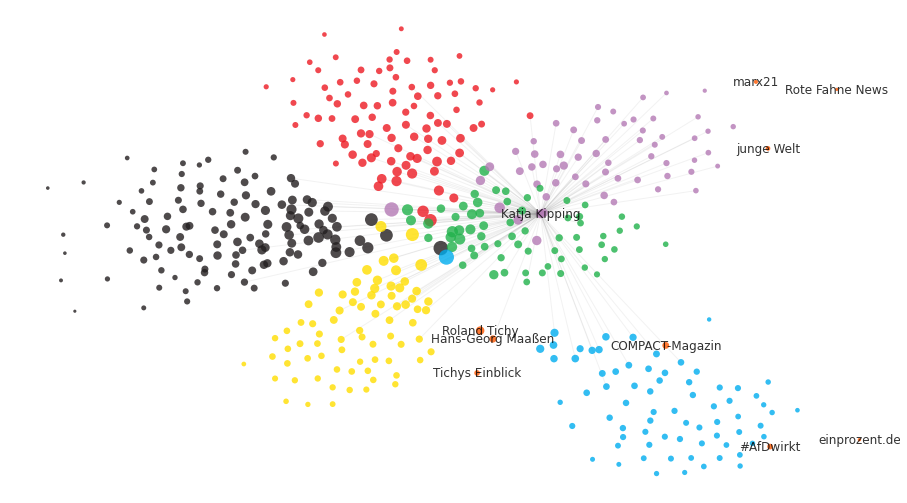

In [9]:
plot_friend_rel_edges(faction="Katja Kipping", get_data_from_DB=False, export=False)